# Book Recommendation System

In [ ]:
!pip install fastai==2.0.10

     |████████████████████████████████| 358kB 6.1MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

In [ ]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.9MB/s 
     |████████████████████████████████| 5.3MB 6.7MB/s 
     |████████████████████████████████| 112kB 46.4MB/s 
     |████████████████████████████████| 133kB 44.7MB/s 
     |████████████████████████████████| 51kB 6.4MB/s 


In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [ ]:
path = Path('goodbooks')
path.mkdir(parents=True, exist_ok=True)

In [ ]:
! kaggle datasets download zygmunt/goodbooks-10k -p "{path}" --unzip

 78% 9.00M/11.6M [00:00<00:00, 14.3MB/s]
100% 11.6M/11.6M [00:00<00:00, 17.0MB/s]


In [ ]:
ratings = pd.read_csv(path/'ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
books = pd.read_csv(path/'books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m/2767052.jpg,https://images.gr-assets.com/books/1447303603s/2767052.jpg
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m/3.jpg,https://images.gr-assets.com/books/1474154022s/3.jpg
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m/41865.jpg,https://images.gr-assets.com/books/1361039443s/41865.jpg
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m/2657.jpg,https://images.gr-assets.com/books/1361975680s/2657.jpg
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m/4671.jpg,https://images.gr-assets.com/books/1490528560s/4671.jpg


In [ ]:
book_ratings = ratings.merge(books[['id', 'title']], left_on='book_id', right_on='id')
book_ratings.head()

,book_id,user_id,rating,id,title
0,1,314,5,1,"The Hunger Games (The Hunger Games, #1)"
1,1,439,3,1,"The Hunger Games (The Hunger Games, #1)"
2,1,588,5,1,"The Hunger Games (The Hunger Games, #1)"
3,1,1169,4,1,"The Hunger Games (The Hunger Games, #1)"
4,1,1185,4,1,"The Hunger Games (The Hunger Games, #1)"


In [ ]:
book_ratings.rating.min(), book_ratings.rating.max()

(1, 5)

In [ ]:
dls = CollabDataLoaders.from_df(book_ratings, user_name='user_id', item_name='title', rating_name='rating', bs=64)

In [ ]:
dls.show_batch()

,user_id,title,rating
0,29287,"Ark Angel (Alex Rider, #6)",4
1,30167,"The Innovators: How a Group of Hackers, Geniuses and Geeks Created the Digital Revolution",4
2,26825,Financial Peace Revisited,4
3,42695,"The Battle for Skandia (Ranger's Apprentice, #4)",5
4,47408,Winter's Bone,5
5,30681,Dreamcatcher,4
6,37144,"Grave Dance (Alex Craft, #2)",5
7,4236,"Blind Willow, Sleeping Woman",3
8,7457,The Naked Face,2
9,34283,The Ice Twins,4


## EmbeddingDotBias Model

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [ ]:
learn.summary()

EmbeddingDotBias (Input shape: ['64 x 2'])
Layer (type)         Output Shape         Param #    Trainable 
Embedding            64 x 50              2,651,700  True      
________________________________________________________________
Embedding            64 x 50              498,250    True      
________________________________________________________________
Embedding            64 x 1               53,034     True      
________________________________________________________________
Embedding            64 x 1               9,965      True      
________________________________________________________________

Total params: 3,212,949
Total trainable params: 3,212,949
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f363ae7ec80>
Loss function: FlattenedLoss of MSELoss()

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

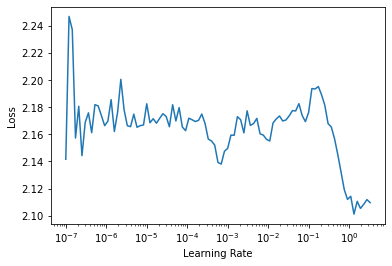

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_min, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.836295,1.860142,02:23
1,1.911268,1.858519,02:24
2,1.715129,1.719781,02:24
3,1.333959,1.332779,02:24
4,1.063028,1.072152,02:23


In [ ]:
learn.save('goodbooks-dot-1')

Path('models/goodbooks-dot-1.pth')

## EmbeddingNN Model

In [ ]:
learn = collab_learner(dls, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(0, 5.5))

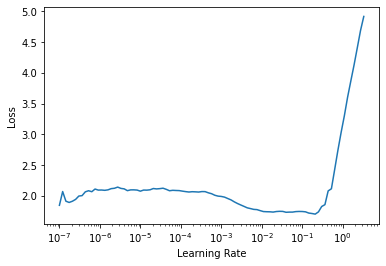

In [ ]:
lr_min, lr_steep = learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, lr_min, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.881903,0.891226,02:57
1,0.883931,0.888753,02:58
2,0.846806,0.856416,02:57
3,0.781652,0.791313,02:58
4,0.724421,0.719955,02:56


In [ ]:
learn.save('goodbooks-nn-1')

Path('models/goodbooks-nn-1.pth')

## Interpretation

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.load('goodbooks-dot-1');

In [ ]:
g = book_ratings.groupby('title')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books[:10]

array(['Selected Poems', 'Stone Soup', 'Invisible', 'The List',
       'Selected Stories', 'Between the Lines (Between the Lines, #1)',
       'The Collected Poems', 'The Complete Stories and Poems', 'Bambi',
       'Are You My Mother?'], dtype=object)

## Book Bias

In [ ]:
book_bias = learn.model.bias(top_books, is_item=True)

In [ ]:
mean_ratings = book_ratings.groupby('title')['rating'].mean()
book_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_books, book_bias)]

In [ ]:
item0 = lambda o:o[0]

In [ ]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.0766), 'Left Behind (Left Behind, #1)', 2.92),
 (tensor(-0.0344), 'Message in a Bottle', 3.11),
 (tensor(-0.0135), 'Moby-Dick or, The Whale', 3.24),
 (tensor(-0.0097), 'Memnoch the Devil (The Vampire Chronicles, #5)', 3.36),
 (tensor(-0.0096), 'Men Are from Mars, Women Are from Venus', 3.25),
 (tensor(0.0116), 'Lost', 2.74),
 (tensor(0.0168), 'How to Be Popular', 3.27),
 (tensor(0.0191), 'How to Be Good', 2.99),
 (tensor(0.0201), 'Love Story (Love Story, #1)', 3.27),
 (tensor(0.0209), 'Mad About the Boy (Bridget Jones, #3)', 3.16),
 (tensor(0.0215), 'Halo (Halo, #1)', 3.26),
 (tensor(0.0224),
  'MWF Seeking BFF: My Yearlong Search For A New Best Friend',
  3.26),
 (tensor(0.0231), 'Labyrinth (Languedoc, #1)', 3.11),
 (tensor(0.0273), 'Last Night at Chateau Marmont', 3.07),
 (tensor(0.0368), 'Hausfrau', 2.98)]

In [ ]:
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.5754), 'Miss Rumphius', 4.61),
 (tensor(0.5616),
  "It's a Magical World: A Calvin and Hobbes Collection",
  4.75),
 (tensor(0.5573), "One Flew Over the Cuckoo's Nest", 4.276923076923077),
 (tensor(0.5250), 'Harry Potter Collection (Harry Potter, #1-6)', 4.72),
 (tensor(0.5201), 'The Complete Stories', 4.32),
 (tensor(0.5132), 'Locke & Key, Vol. 5: Clockworks', 4.66),
 (tensor(0.5094), 'Jesus the Christ', 4.67),
 (tensor(0.5002),
  'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
  4.77),
 (tensor(0.4970), 'The Complete Poems', 4.165),
 (tensor(0.4921), 'Anatomy for the Artist', 4.121387283236994),
 (tensor(0.4887), 'L.A. Requiem (Elvis Cole, #8)', 4.29),
 (tensor(0.4819), 'Selected Poems', 4.08),
 (tensor(0.4806), 'Jimmy Corrigan, the Smartest Kid on Earth', 4.19),
 (tensor(0.4724), 'Selected Stories', 4.145),
 (tensor(0.4697), 'The Collected Poems', 4.17)]

## Book Weights

In [ ]:
book_w = learn.model.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 50])

In [ ]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books)]

In [ ]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.6268), 'The Complete Stories and Poems'),
 (tensor(0.5970), 'The Little Mermaid'),
 (tensor(0.5659), "Little Bear's Friend"),
 (tensor(0.5478), 'How the Grinch Stole Christmas!'),
 (tensor(0.5444), 'Lyle, Lyle, Crocodile'),
 (tensor(0.5200), 'Pinocchio'),
 (tensor(0.5130), "Madeline's Rescue"),
 (tensor(0.4886), 'Miss Nelson Is Back (Miss Nelson, #2)'),
 (tensor(0.4748), 'Me Talk Pretty One Day'),
 (tensor(0.4691), 'How Do Dinosaurs Say Good Night?')]

In [ ]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.7042), 'Judgment in Death (In Death, #11)'),
 (tensor(-0.6298), 'Law Man (Dream Man, #3)'),
 (tensor(-0.5946), 'Lead (Stage Dive, #3)'),
 (tensor(-0.5822), 'Kindred in Death (In Death, #29)'),
 (tensor(-0.5599), 'Loyalty in Death (In Death, #9)'),
 (tensor(-0.5581), 'Leave Me Breathless (Ross Siblings, #3)'),
 (tensor(-0.5488), 'Imitation in Death (In Death, #17)'),
 (tensor(-0.5483), 'Lady Luck (Colorado Mountain, #3)'),
 (tensor(-0.4985), 'Jet (Marked Men, #2)'),
 (tensor(-0.4935), "Mistral's Kiss (Merry Gentry, #5)")]

In [ ]:
book_comp = [(f, i) for f,i in zip(fac1, top_books)]

In [ ]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.4463), 'Hey Nostradamus!'),
 (tensor(0.4206),
  'Love Wins: A Book About Heaven, Hell, and the Fate of Every Person Who Ever Lived'),
 (tensor(0.4180), 'Hidden Bodies (You, #2)'),
 (tensor(0.4013), 'Lucky Us'),
 (tensor(0.3935), 'Juliet, Naked'),
 (tensor(0.3919), "Love the One You're With"),
 (tensor(0.3911), 'Little Altars Everywhere'),
 (tensor(0.3908), 'Memnoch the Devil (The Vampire Chronicles, #5)'),
 (tensor(0.3825), 'I Am Having So Much Fun Here Without You'),
 (tensor(0.3750), 'How to Talk to a Widower')]

In [ ]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.6480), 'Lover Mine (Black Dagger Brotherhood, #8)'),
 (tensor(-0.5672), 'Kiss of the Night (Dark-Hunter, #4)'),
 (tensor(-0.5285), 'Law Man (Dream Man, #3)'),
 (tensor(-0.5265), 'Magic Bleeds (Kate Daniels, #4)'),
 (tensor(-0.5262), 'Magic Slays (Kate Daniels, #5)'),
 (tensor(-0.5226), 'Kiss of Crimson (Midnight Breed, #2)'),
 (tensor(-0.4988), 'Imitation in Death (In Death, #17)'),
 (tensor(-0.4927), 'Loyalty in Death (In Death, #9)'),
 (tensor(-0.4888), 'Lothaire (Immortals After Dark #12)'),
 (tensor(-0.4800), 'Kiss of a Demon King (Immortals After Dark #7)')]

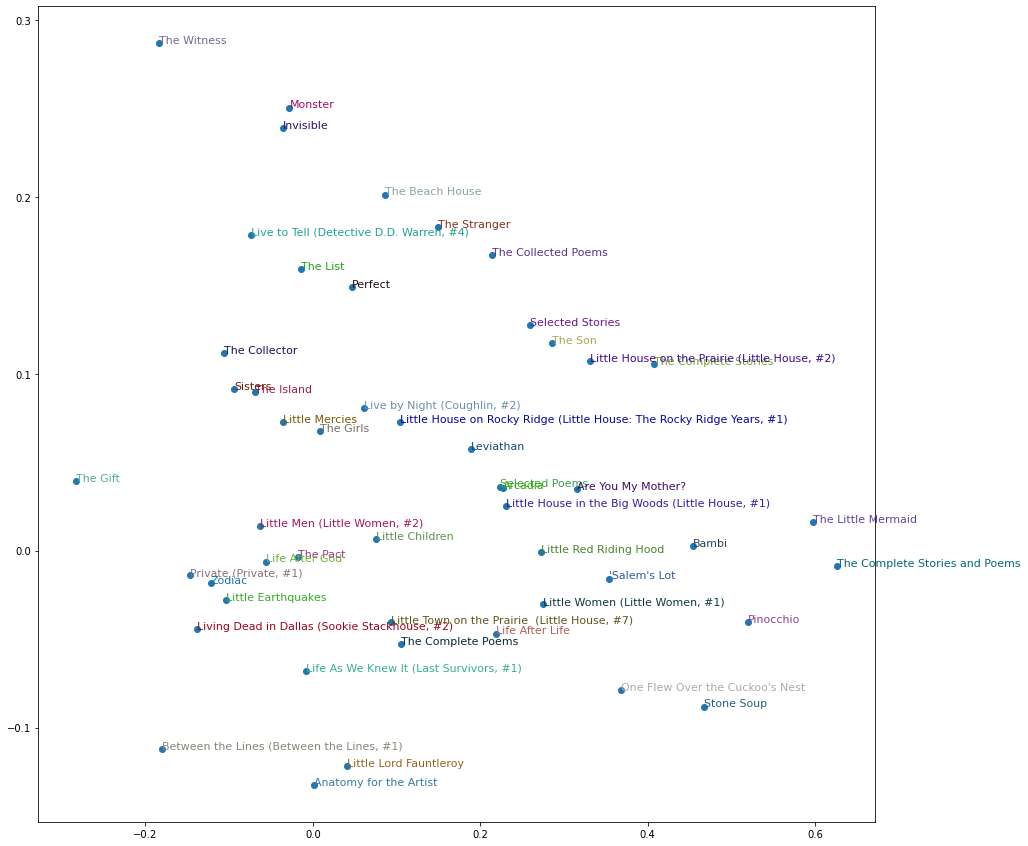

In [ ]:
idxs = np.random.choice(len(top_books), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()